In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import json
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/drive/MyDrive/Surprise_Storm"

sys.path.append('/content/drive/MyDrive')

Mounted at /content/drive


In [ ]:
from Utility_funcs.window_test_dataloader import StormDataLoader, WindStormDataset, ImageStormDataset, WSStormDataset

In [ ]:
# Assuming your images are stored in the main_repo/images directory
images_directory = root_dir

# Create an instance of WindowDataLoader
window_dataloader = StormDataLoader(images_directory)

# Load the trained model
model_path = "/content/drive/MyDrive/Yolanda-Task1/"


In [ ]:
class StormDataset(Dataset):
    """
    Custom dataset class for storm data.

    Args:
        root_dir (str): Root directory containing storm data.
        storm_id (str or list of str): Storm IDs for the dataset.
        sequence_length (int): Length of sequences to extract.
        split (str): Dataset split ('train' or 'test').
        test_size (float): Proportion of data to use for testing (if split is 'train').

    Attributes:
        root_dir (str): Root directory containing storm data.
        sequence_length (int): Length of sequences to extract.
        transform (torchvision.transforms.Compose): Image transformations.
        storm_id (str or list of str): Storm IDs for the dataset.
        sequences (list): List of sequences containing images, features, and labels.

    Methods:
        _load_and_process_data(): Loads and processes storm data.
    """

    def __init__(self, root_dir, storm_id, sequence_length=15, split='train', test_size=0.2):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])
        self.storm_id = storm_id
        self.sequences = []
        self._load_and_process_data()

        # Split the dataset into train and test sets
        train_sequences, test_sequences = train_test_split(self.sequences, test_size=test_size, random_state=42)
        self.sequences = train_sequences if split == 'train' else test_sequences

    def _load_and_process_data(self):
        """
        Load and process storm data, extracting sequences of images, features, and labels.
        """
        time_features = []

        storms = self.storm_id

        for storm_id in storms:
            storm_path = os.path.join(self.root_dir, storm_id)
            all_files = os.listdir(storm_path)

            temp_images = []
            temp_features = []
            temp_labels = []

            for file in sorted(all_files):
                if file.endswith('.jpg'):
                    image_path = os.path.join(storm_path, file)
                    image = Image.open(image_path)
                    temp_images.append(self.transform(image))
                elif file.endswith('_features.json') or file.endswith('_label.json'):
                    with open(os.path.join(storm_path, file), 'r') as f:
                        data = json.load(f)
                        if file.endswith('_features.json'):
                            temp_features.append([float(data['relative_time']), float(data['ocean'])])
                        else:
                            temp_labels.append(float(data['wind_speed']))
            max_relative_time = max([f[0] for f in temp_features])
            for feature in temp_features:
                feature[0] /= max_relative_time
            time_features.extend([f[0] for f in temp_features])

            for i in range(len(temp_images) - self.sequence_length):
                self.sequences.append({
                    'images': temp_images[i:i + self.sequence_length],
                    'features': temp_features[i:i + self.sequence_length],
                    'labels': temp_labels[i:i + self.sequence_length]
                })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        return {
            'images': torch.stack(sequence['images']),
            'features': torch.tensor(sequence['features'], dtype=torch.float),
            'labels': torch.tensor(sequence['labels'], dtype=torch.float)
        }

In [ ]:
import unittest
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision.transforms import Resize, Grayscale, ToTensor
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import json

class StormDatasetTest(unittest.TestCase):
    def setUp(self):
        # Setup common parameters for tests
        self.root_dir = '/content/drive/MyDrive/Selected_Storms_curated/Selected_Storms_curated_to_zip'
        self.storm_id = ['bkh']
        self.sequence_length = 11
        self.dataset = StormDataset(root_dir=self.root_dir, storm_id=self.storm_id, sequence_length=self.sequence_length, split='train')

    def test_dataset_loading(self):
        sample = self.dataset[0]
        self.assertEqual(sample['images'].shape, (self.sequence_length, 1, 224, 224), "Input sequence shape is incorrect")
        self.assertEqual(sample['features'].shape, (self.sequence_length, 2), "Features shape is incorrect for each sequence step")
        self.assertEqual(sample['labels'].shape, (self.sequence_length,), "Labels shape is incorrect for each sequence step")

    def test_unique_storms_count(self):
        # The number of unique storms should match the length of the storm_id list provided to the dataset
        expected_count = len(self.storm_id)
        # Directly compare this to the length of the storm_ids list since each id represents a unique storm
        self.assertEqual(expected_count, len(set(self.storm_id)), "The number of unique storms does not match the expected count")


    def test_image_transformations(self):
        sample = self.dataset[0]
        image = sample['images'][0]  # Assuming the first image in the sequence
        self.assertEqual(image.shape[0], 1, "Image should be converted to grayscale")
        self.assertEqual(image.shape[1:], (224, 224), "Image size should be resized to 224x224")

    def test_feature_normalization(self):
        sample = self.dataset[0]
        features = sample['features']
        # Verifying normalized feature 'relative_time' as an example
        normalized_values = features[:, 0]  # Assuming first feature is 'relative_time'
        self.assertTrue(torch.all((0 <= normalized_values) & (normalized_values <= 1)), "Feature values should be normalized between 0 and 1")

    def test_label_processing(self):
        sample = self.dataset[0]
        labels = sample['labels']
        self.assertTrue(torch.is_tensor(labels), "Labels should be a PyTorch tensor")



if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


In [ ]:
class StormDatasetTest(unittest.TestCase):
    def setUp(self):
        # Setup common parameters for tests
        self.root_dir = '/content/drive/MyDrive/Selected_Storms_curated'
        self.storm_ids = ['bkh']  # Assuming 'bkh' is a valid storm ID in your dataset
        self.sequence_length = 11
        self.dataset = StormDataset(root_dir=self.root_dir, storm_id=self.storm_ids, sequence_length=self.sequence_length, split='train')

    def test_sequence_lengths(self):
        for storm_id in self.storm_ids:
            sequences = [seq for seq in self.dataset.sequences if seq['storm_id'] == storm_id]
            for sequence in sequences:
                self.assertEqual(len(sequence['images']), self.sequence_length, f"Sequence length for storm {storm_id} is incorrect")


    def test_data_ranges(self):
        sample = self.dataset[0]
        images, features = sample['images'], sample['features']
        self.assertTrue(images.min() >= 0 and images.max() <= 1, "Image data should be normalized")
        # Assuming features are normalized or scaled to a specific range
        self.assertTrue(features.min() >= 0 and features.max() <= 1, "Feature data should be scaled properly")

    def test_unique_data_per_storm(self):
        data_check = set()
        for sequence in self.dataset.sequences:
            storm_id = sequence['storm_id']
            for image_path in sequence['image_paths']:  # Assuming you have paths or some identifiers for uniqueness
                data_identifier = (storm_id, image_path)
                self.assertNotIn(data_identifier, data_check, f"Duplicate data found for storm {storm_id}")
                data_check.add(data_identifier)

    def test_completeness_of_data(self):
        for sequence in self.dataset.sequences:
            self.assertTrue('images' in sequence and 'features' in sequence and 'labels' in sequence, "Missing data elements in a sequence")
            self.assertEqual(len(sequence['images']), len(sequence['features']), "Mismatched number of images and features")
            self.assertEqual(len(sequence['images']), len(sequence['labels']), "Mismatched number of images and labels")

    def test_correct_association_with_storm_id(self):
        for storm_id in self.storm_ids:
            sequences = [seq for seq in self.dataset.sequences if seq['storm_id'] == storm_id]
            for sequence in sequences:
                # Perform validation against external criteria, such as checking sequence metadata
                self.assertTrue(self.validate_sequence_with_external_criteria(sequence, storm_id), f"Data for storm {storm_id} does not match external criteria")

    if __name__ == '__main__':
        unittest.main(argv=[''], exit=False)

In [ ]:
class DataLoaderTest(unittest.TestCase):
    def setUp(self):
        # Setup common parameters for tests
        self.root_dir = '/content/drive/MyDrive/Selected_Storms_curated/Selected_Storms_curated_to_zip'
        self.storm_id = ['bkh']
        self.sequence_length = 11
        self.batch_size = 32
        self.train_dataset = StormDataset(root_dir=self.root_dir, storm_id=self.storm_id, sequence_length=self.sequence_length, split='train')
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def test_dataloader_output(self):
        batch = next(iter(self.train_loader))
        images, features, labels = batch['images'], batch['features'], batch['labels']

        self.assertEqual(images.shape, (self.batch_size, self.sequence_length, 1, 224, 224), "Batched images shape is incorrect")
        self.assertEqual(features.shape, (self.batch_size, self.sequence_length, 2), "Batched features shape is incorrect")
        self.assertEqual(labels.shape, (self.batch_size, self.sequence_length), "Batched labels shape is incorrect")

    def test_total_images_processed(self):
        total_images = 0
        for batch in self.train_loader:
            total_images += batch['images'].size(0) * batch['images'].size(1)  # batch size * sequence length

        expected_total_images = len(self.train_dataset) * self.sequence_length
        self.assertEqual(total_images, expected_total_images, f"Total processed images should be {expected_total_images}, got {total_images}")

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


## Task 1

In [ ]:
# Function to retrieve a list of storm IDs from a specified directory
def get_storm_ids(root_dir):
    """
    Get a list of storm IDs from the specified directory.

    Args:
        root_dir (str): The root directory containing storm data folders.

    Returns:
        list: A list of storm IDs.
    """
    storm_ids = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]
    return storm_ids

# Set the root directory for storm data
root_dir = '/content/drive/MyDrive/Selected_Storms_curated'

# Initialize the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the list of storm IDs using the get_storm_ids function
storms = get_storm_ids(root_dir)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

root_dir = '/content/drive/MyDrive/Selected_Storms_curated'

train_dataset = StormDataset(root_dir, storm_id=storms, sequence_length=11, split='train')
val_dataset = StormDataset(root_dir, storm_id=storms, sequence_length=11, split='test')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

In [ ]:
import torch.nn as nn
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_channel = input_dim
        self.hidden_channel = hidden_dim
        self.kernel_sz = kernel_size
        self.pad = kernel_size[0] // 2, kernel_size[1] // 2
        self.use_bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_channel + self.hidden_channel,
                              out_channels=4 * self.hidden_channel,
                              kernel_size=self.kernel_sz,
                              padding=self.pad,
                              bias=self.use_bias)
    def forward(self, input_tensor, cur_state):
        h_current, c_current = cur_state
        combined = torch.cat([input_tensor, h_current], dim=1)
        conv_result = self.conv(combined)
        cc_inputgate, cc_forgetgate, cc_outputgate, cc_cellgate = torch.split(conv_result, self.hidden_channel, dim=1)
        input_gate = torch.sigmoid(cc_inputgate)
        forget_gate = torch.sigmoid(cc_forgetgate)
        output_gate = torch.sigmoid(cc_outputgate)
        cell_gate = torch.tanh(cc_cellgate)
        c_next = forget_gate * c_current + input_gate * cell_gate
        h_next = output_gate * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channel, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_channel, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()
        self._check_kernel_size_consistency(kernel_size)
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]
            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))
        self.cell_list = nn.ModuleList(cell_list)
    def forward(self, input_tensor, hidden_state=None):
        if not self.batch_first:
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)
        b, _, _, h, w = input_tensor.size()
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))
        layer_output_list = []
        last_state_list = []
        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)
            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output
            layer_output_list.append(layer_output)
            last_state_list.append([h, c])
        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]
        return layer_output_list, last_state_list

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states



In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.conv_layers(x)

class StormGenerator(nn.Module):
    def __init__(self):
        super(StormGenerator, self).__init__()
        self.encoder = SimpleCNN()
        self.conv_lstm = ConvLSTM(input_dim=128, hidden_dim=[64, 32], kernel_size=(3, 3), num_layers=2, batch_first=True)
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),
          nn.Tanh()
      )
    def forward(self, input_imgs):
        batch_size, sequence_len, c, h, w = input_imgs.size()
        c_input = input_imgs.reshape(batch_size * sequence_len, c, h, w)
        c_output = self.encoder(c_input)
        c_output = c_output.view(batch_size, sequence_len, -1, h // 8, w // 8)
        conv_lstm_out, _ = self.conv_lstm(c_output)
        conv_lstm_out = conv_lstm_out[0][:, -1, :, :, :]
        output_image = self.decoder(conv_lstm_out)
        return output_image


model = StormGenerator()


In [ ]:
from pytorch_msssim import ssim
import torch
import matplotlib.pyplot as plt

def train(model, train_loader, optimizer, device):
    model.train()  # Set the model to training mode
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['images'].to(device)


            input_images = images[:, :5, :, :, :]  # Use the first five images as input sequence
            target_image = images[:, 7, :, :, :].squeeze(1)  # Use the 8th image as target
            target_image = target_image.unsqueeze(1)

            optimizer.zero_grad()

            predicted_image = model(input_images)

            # Calculate loss using SSIM
            loss = 1 - ssim(predicted_image, target_image, data_range=1, size_average=True)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)  # Store the average loss for this epoch

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()


In [ ]:
from pytorch_msssim import ssim
import torch
import matplotlib.pyplot as plt

def train(model, train_loader, optimizer, device):
    model.train()  # Set the model to training mode
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            images = batch['images'].to(device)


            input_images = images[:, :5, :, :, :]  # Use the first five images as input sequence
            target_image = images[:, 7, :, :, :].squeeze(1)  # Use the 8th image as target
            target_image = target_image.unsqueeze(1)

            optimizer.zero_grad()

            predicted_image = model(input_images)

            # Calculate loss using SSIM
            loss = 1 - ssim(predicted_image, target_image, data_range=1, size_average=True)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)  # Store the average loss for this epoch

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()


In [ ]:
#SSIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StormGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 60
train(model, train_loader, optimizer, device)

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def eval(model, data_loader, device):
    # we can choose to use the model parameters which we already trained.
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = StormGenerator().to(device)
    # model.load_state_dict(torch.load('/content/drive/MyDrive/surprise_storm_100_ssim0.25_model.pth'))
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            images = batch['images'].to(device)


            input_images = images[:, :5, :, :, :]  # Use the first five images as input sequence
            target_image = images[:, 7, :, :, :].squeeze(1)  # Use the 8th image as target

            # Generate prediction
            predicted_image = model(input_images)

            if batch_idx == 0:  # Just show the first batch
                fig, axs = plt.subplots(2, 1, figsize=(10, 5))

                # Show target image
                axs[0].set_title('Target Image')
                axs[0].imshow(target_image[0].cpu().numpy(), cmap='gray')
                axs[0].axis('off')

                # Show predicted image
                axs[1].set_title('Predicted Image')
                axs[1].imshow(predicted_image[0].squeeze().cpu().numpy(), cmap='gray')
                axs[1].axis('off')

                plt.show()
                break  # only show one set of images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eval(model, val_loader, device)



In [ ]:
surprise_dir = '/content/drive/MyDrive/Surprise_Storm/'
surprise_storm = ['tst']
surprise_dataset = StormDataset(surprise_dir, storm_id=surprise_storm, sequence_length=11, split='train')
surprise_loader = DataLoader(surprise_dataset, batch_size=1, shuffle=False, num_workers=3)
print(len(surprise_loader))

In [ ]:
def eval_continuous_prediction(model, data_loader, device, start_batch=1, num_predictions=3):

    # we can use the model we trained before.
    # model = StormGenerator().to(device)
    # model.load_state_dict(torch.load('/content/drive/MyDrive/surprise_storm_100_ssim0.25_model.pth'))
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            images = batch['images'].to(device)


            input_sequence = images[:, :5, :, :, :]
            iter = 5
            predicted_images = []
            for _ in range(num_predictions):
                # Generate prediction for the next image
                predicted_image = model(input_sequence)
                predicted_images.append(predicted_image)
                input_sequence = torch.cat((input_sequence[:, 1:, :, :, :], images[:,iter , :, :, :].unsqueeze(1)), dim=1)
                iter += 1
            if batch_idx == start_batch:  # Show and save images for the start_batch
                print(batch['images'].shape)
                # Display and save predicted images
                fig, axs = plt.subplots(1, num_predictions, figsize=(15, 5))
                for i in range(num_predictions):

                    # Show predicted image
                    axs[i].set_title(f'Predicted Image {i+1}')
                    predicted_img = predicted_images[i][0].squeeze().cpu().numpy()
                    axs[i].imshow(predicted_img, cmap='gray')
                    axs[i].axis('off')

                    # Save predicted image
                    save_path = f'/content/drive/MyDrive/Yolanda_generatedimages_85to1/tst{i+252}.jpg'
                    plt.imsave(save_path, predicted_img, cmap='gray')
                    print(f'Saved predicted image {i+1} at {save_path}')

                plt.show()
                break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eval_continuous_prediction(model, surprise_loader, device,start_batch = 194)

## Task 2

In [195]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
import os
import torchvision.transforms as transforms
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [164]:
import sys

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
root_dir = "/content/drive/MyDrive/Surprise_Storm"
gen_dir = "/content/drive/MyDrive/"
model_dir = "/content/drive/MyDrive/lstm_model_surprise.pth"

In [166]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        """
        Initialize a feature extractor module using a pretrained ResNet18 model.
        """
        super(FeatureExtractor, self).__init__()
        self.output_dim = 256  # Dimension of the output features
        # Load a pretrained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=False)

        # Freeze the parameters of ResNet18 to prevent updates during training
        for param in self.resnet18.parameters():
            param.requires_grad = True

        # Modify the last fully connected layer of ResNet18 to match the desired output dimension
        self.resnet18.fc = nn.Sequential(
            nn.Linear(512, self.output_dim),  # Input: 512-dimensional features, Output: output_dim-dimensional features
            nn.ReLU(),
        )

    def forward(self, x):
        """
        Forward pass to extract features from input images.

        Args:
            x (torch.Tensor): Input images.

        Returns:
            torch.Tensor: Extracted features.
        """
        # Forward pass through ResNet18
        x = self.resnet18(x)
        return x

class Modified_STA_LSTM(nn.Module):
    def __init__(self, time_feature_dim=2, lstm_hidden_dim=500, out_dim=1, use_gpu=False):
        """
        Initialize a Modified STA-LSTM model.

        Args:
            time_feature_dim (int): Dimensionality of time features.
            lstm_hidden_dim (int): Dimensionality of the LSTM hidden state.
            out_dim (int): Dimensionality of the output.
            use_gpu (bool): Whether to use GPU for computations.
        """
        super(Modified_STA_LSTM, self).__init__()
        # Parameter initialization
        self.feature_extractor = FeatureExtractor()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.out_dim = out_dim
        self.use_gpu = use_gpu

        # Network architecture
        # Assuming the output dimension of feature_extractor is known
        combined_feature_dim = self.feature_extractor.output_dim + time_feature_dim
        self.lstm = nn.LSTM(combined_feature_dim, lstm_hidden_dim, batch_first=True)
        self.extra_fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 256),  # Input: lstm_hidden_dim-dimensional features, Output: 256-dimensional features
            nn.ReLU(),
            nn.Linear(256, 128),   # Input: 256-dimensional features, Output: 128-dimensional features
            nn.ReLU(),
            nn.Linear(128, out_dim),   # Input: 128-dimensional features, Output: out_dim-dimensional features
        )

    def forward(self, images, time_features):
        """
        Forward pass of the Modified STA-LSTM model.

        Args:
            images (torch.Tensor): Input images.
            time_features (torch.Tensor): Time-related features.

        Returns:
            torch.Tensor: Model output.
        """
        # Extract image features
        batch_size, sequence_length, C, H, W = images.size()
        cnn_input = images.view(batch_size * sequence_length, C, H, W)
        image_features = self.feature_extractor(cnn_input)
        image_features = image_features.view(batch_size, sequence_length, -1)

        # Ensure the time features have the correct dimension
        time_features = time_features.view(batch_size, sequence_length, -1)

        # Concatenate image features and time features
        combined_features = torch.cat([image_features, time_features], dim=2)

        # Process through LSTM
        lstm_out, _ = self.lstm(combined_features)
        # Take the output of the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Pass through additional fully connected layers and activation functions
        out = self.extra_fc(last_time_step_out)
        return out


In [167]:
class StormDataset(Dataset):
    """
    Custom dataset class for storm data.

    Args:
        root_dir (str): Root directory containing storm data.
        storm_id (str or list of str): Storm IDs for the dataset.
        sequence_length (int): Length of sequences to extract.
        split (str): Dataset split ('train' or 'test').
        test_size (float): Proportion of data to use for testing (if split is 'train').

    Attributes:
        root_dir (str): Root directory containing storm data.
        sequence_length (int): Length of sequences to extract.
        transform (torchvision.transforms.Compose): Image transformations.
        storm_id (str or list of str): Storm IDs for the dataset.
        sequences (list): List of sequences containing images, features, and labels.

    Methods:
        _load_and_process_data(): Loads and processes storm data.
    """

    def __init__(self, root_dir, storm_id, sequence_length=15, split=False, shuffle_data=True, test_size=0.2):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
        self.storm_id = storm_id
        self.sequences = []
        self._load_and_process_data()
        if split:
            # Split the dataset into train and test sets
            train_sequences, test_sequences = train_test_split(self.sequences, test_size=test_size, random_state=42)
            self.sequences = train_sequences if split == 'train' else test_sequences

    def _load_and_process_data(self):
        """
        Load and process storm data, extracting sequences of images, features, and labels.
        """
        time_features = []

        storms = self.storm_id

        for storm_id in storms:
            storm_path = os.path.join(self.root_dir, storm_id)
            all_files = os.listdir(storm_path)

            temp_images = []
            temp_features = []
            temp_labels = []

            for file in sorted(all_files):
                if file.endswith('.jpg'):
                    image_path = os.path.join(storm_path, file)
                    image = Image.open(image_path)
                    temp_images.append(self.transform(image))
                elif file.endswith('_features.json') or file.endswith('_label.json'):
                    with open(os.path.join(storm_path, file), 'r') as f:
                        data = json.load(f)
                        if file.endswith('_features.json'):
                            temp_features.append([float(data['relative_time']), float(data['ocean'])])
                        else:
                            temp_labels.append(float(data['wind_speed']))
            max_relative_time = max([f[0] for f in temp_features])
            for feature in temp_features:
                feature[0] /= max_relative_time
            time_features.extend([f[0] for f in temp_features])

            for i in range(len(temp_images) - self.sequence_length):
                self.sequences.append({
                    'images': temp_images[i:i + self.sequence_length],
                    'features': temp_features[i:i + self.sequence_length],
                    'labels': temp_labels[i:i + self.sequence_length]
                })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        return {
            'images': torch.stack(sequence['images']),
            'features': torch.tensor(sequence['features'], dtype=torch.float),
            'labels': torch.tensor(sequence['labels'], dtype=torch.float)
        }


In [168]:
class Surprise_StormDataset(Dataset):
    """
    A custom dataset class designed for loading and processing storm-related data for machine learning models.

    This dataset class is tailored to work with images and associated features of storms,
    allowing for the extraction of sequential data that can be used for temporal analysis or prediction models.

    Parameters:
        root_dir (str): The root directory where the storm data is stored.
                        This should contain subdirectories for each storm, each with images and feature files.
        storm_id (str or list of str): A single storm ID or a list of storm IDs that the dataset will cover.
        sequence_length (int): The number of consecutive images (and their features) to include in a single sequence.

    Attributes:
        root_dir (str): Stores the root directory for storm data.
        sequence_length (int): The length of the sequences that will be extracted from the data.
        transform (torchvision.transforms.Compose): A series of torchvision transforms for preprocessing the images.
        storm_id (str or list of str): The list of storm IDs included in the dataset.
        sequences (list): A list where each element is a sequence containing images, features, and optionally labels.
    """

    def __init__(self, root_dir, storm_id=["tst"], sequence_length=15):
        """
        Initializes the dataset object, sets up the transformations for the images, and starts the data loading process.
        """
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images to 224x224
            transforms.Grayscale(num_output_channels=3),  # Convert images to grayscale with 3 channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.storm_id = storm_id
        self.sequences = []  # Initialize an empty list to hold the data sequences
        self._load_and_process_data()  # Start loading and processing the data

    def _load_and_process_data(self):
        """
        Loads and processes the storm data by reading the images and their associated features from the filesystem.
        It constructs sequences of a specified length from consecutive images and features.
        """
        for storm_id in self.storm_id:
            storm_path = os.path.join(self.root_dir, storm_id)
            all_files = os.listdir(storm_path)

            temp_images = []
            temp_features = []

            # Loop through each file in the storm's directory
            for file in sorted(all_files):
                if file.endswith('.jpg'):  # For image files
                    image_path = os.path.join(storm_path, file)
                    image = Image.open(image_path)
                    temp_images.append(self.transform(image))  # Apply transformations and store the image
                elif file.endswith('_features.json'):  # For feature files
                    with open(os.path.join(storm_path, file), 'r') as f:
                        data = json.load(f)
                        temp_features.append([float(data['relative_time']), float(data['ocean'])])  # Store features

            # Normalize the 'relative_time' feature by the maximum time for this storm
            max_relative_time = max([f[0] for f in temp_features])
            for feature in temp_features:
                feature[0] /= max_relative_time

            # Construct sequences from the images and features
            for i in range(len(temp_images) - self.sequence_length+1):
                self.sequences.append({
                    'images': temp_images[i:i + self.sequence_length],
                    'features': temp_features[i:i + self.sequence_length],
                })

    def __len__(self):
        """
        Returns the total number of sequences in the dataset.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Retrieves a specific sequence from the dataset by index.

        Parameters:
            idx (int): The index of the sequence to retrieve.

        Returns:
            A dictionary containing the sequence's images and features.
        """
        sequence = self.sequences[idx]
        return {
            'images': torch.stack(sequence['images']),  # Stack images into a single tensor
            'features': torch.tensor(sequence['features'], dtype=torch.float),  # Convert features to a tensor
        }


In [172]:
# Function to retrieve a list of storm IDs from a specified directory
def get_storm_ids(root_dir):
    """
    Get a list of storm IDs from the specified directory.

    Args:
        root_dir (str): The root directory containing storm data folders.

    Returns:
        list: A list of storm IDs.
    """
    storm_ids = [name for name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, name))]
    return storm_ids

# Initialize the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the list of storm IDs using the get_storm_ids function
storms = get_storm_ids(root_dir)


In [170]:
# Create an instance of the model with the same structure as the original one
loaded_model = Modified_STA_LSTM().to(device)

# Load the saved model state dictionary
loaded_model.load_state_dict(torch.load(model_dir))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [173]:
storms_dataset = StormDataset(root_dir, storm_id=storms)
dataset = [storms_dataset[i] for i in range(len(storms_dataset)-12)]
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=3)

In [174]:
# Initialize empty tensors for ground truth (y) and predictions (y_pre)
y = torch.tensor([]).to(device)
y_pre = torch.tensor([]).to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Disable gradient computation (no gradient calculation needed during evaluation)
with torch.no_grad():
    # Iterate through the validation data loader
    for batch in loader:
        # Move input data to the device (GPU)
        images = batch['images'].to(device)
        features = batch['features'].to(device)

        # Extract the labels from the last time step of the sequences
        labels = batch['labels'][:,-1].to(device)

        # Forward pass through the model to get predictions
        outputs = loaded_model(images, features)

        # Concatenate the ground truth and predictions along a specified dimension
        y = torch.cat((y, labels.view(-1)), dim=0)
        y_pre = torch.cat((y_pre, outputs.view(-1)), dim=0)


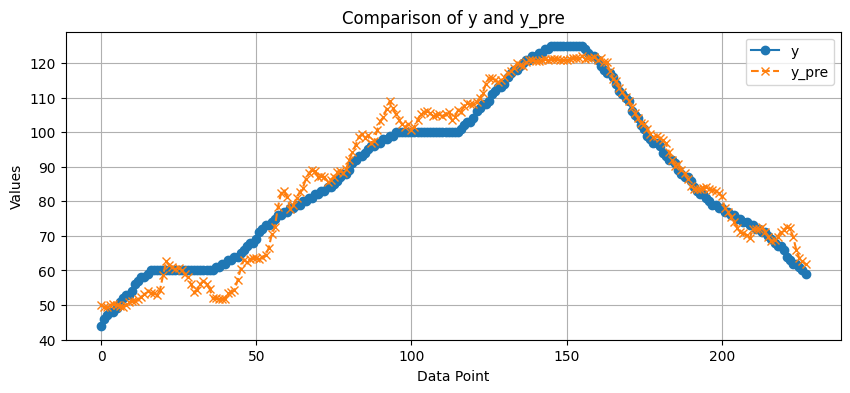

In [175]:
y = y.cpu()
y_pre = y_pre.cpu()
# Create x-axis coordinates
x = np.arange(len(y))

# Create a figure
plt.figure(figsize=(10, 4))

# Plot the line chart for y
plt.plot(x, y, label='y', marker='o', linestyle='-')

# Plot the line chart for y_pre
plt.plot(x, y_pre, label='y_pre', marker='x', linestyle='--')

# Add title and labels
plt.title('Comparison of y and y_pre')
plt.xlabel('Data Point')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the chart
plt.grid(True)
plt.show()


In [176]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrix(y, y_pre):
  mse = mean_squared_error(y,y_pre)  # Convert the result to a scalar using .item()
  rmse = np.sqrt(mse)
  r2 = r2_score(y,y_pre)
  print(f'RMSE: {rmse}')
  print(f'r2: {r2}')

In [177]:
evaluate_metrix(y, y_pre)

RMSE: 4.232571601867676
r2: 0.9639091810663163


In [178]:
storms_dataset = Surprise_StormDataset(root_dir)
storms_loader = DataLoader(storms_dataset, batch_size=1, shuffle=False, num_workers=3)

In [189]:
# Initialize empty tensors for ground truth (y) and predictions (y_pre)
y_pre = torch.tensor([]).to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Disable gradient computation (no gradient calculation needed during evaluation)
with torch.no_grad():
    # Iterate through the validation data loader
    for batch in storms_loader:
        # Move input data to the device (GPU)
        images = batch['images'].to(device)
        features = batch['features'].to(device)

        # Forward pass through the model to get predictions
        outputs = loaded_model(images, features)

        # Concatenate the ground truth and predictions along a specified dimension
        y_pre = torch.cat((y_pre, outputs.view(-1)), dim=0)

In [192]:
y_pre[-13:]

tensor([61.5474, 61.8257, 62.0799, 62.1420, 62.3643, 62.7583, 63.3192, 63.3976,
        62.9730, 62.9940, 63.9591, 63.8941, 64.0156], device='cuda:0')

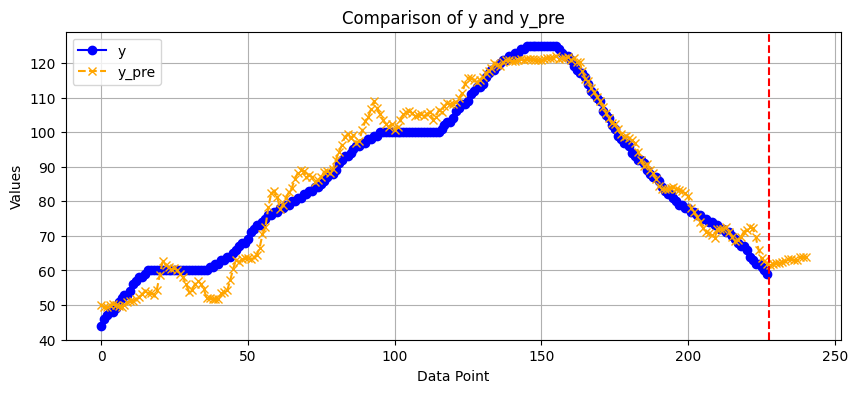

In [193]:
# Convert y_pre from a PyTorch tensor to a numpy array for plotting
y_pre = y_pre.cpu()

# Create x-axis coordinates based on the length of y
x = np.arange(len(y))

# Create a figure with a specified size
plt.figure(figsize=(10, 4))

# Plot the line chart for y using circles ('o') for data points and a solid line ('-') for connections
plt.plot(x, y, label='y', marker='o', linestyle='-', color='blue')

# For y_pre, create x-axis coordinates based on its length
x_pre = np.arange(len(y_pre))

# Plot the line chart for y_pre using 'x' markers and a dashed line ('--')
plt.plot(x_pre, y_pre, label='y_pre', marker='x', linestyle='--', color='orange')

# Add a title to the plot
plt.title('Comparison of y and y_pre')

# Label the x-axis as 'Data Point'
plt.xlabel('Data Point')

# Label the y-axis as 'Values'
plt.ylabel('Values')

# Add a legend to the plot to identify the lines
plt.legend()

# Determine the shorter length between y and y_pre to find where to draw the boundary line
min_length = min(len(y), len(y_pre))

# Draw a vertical red dashed line ('--') at the boundary between y and y_pre lengths
plt.axvline(x=min_length-0.5, color='r', linestyle='--', label='Boundary')

# Enable grid for better readability of the plot
plt.grid(True)

# Display the plot
plt.show()


In [201]:
relative_time = [storms_dataset[i]["features"][-1][0] for i in range(len(storms_dataset))][-13:]

In [205]:
# 假设 y_pre 是一个PyTorch张量，我们将它转换为numpy数组
# 如果y_pre已经是numpy数组，则可以跳过这一步
y_pre_np = y_pre.cpu().numpy() if isinstance(y_pre, torch.Tensor) else y_pre
y_pre_np = y_pre_np[-13:]
# 假设 relative_time 是一个列表或numpy数组
relative_time_np = np.array(relative_time)

# 创建一个DataFrame来存储y_pre和relative time
df = pd.DataFrame({
    'Relative Time': relative_time_np,
    'Predictions': np.round(y_pre_np)
})

# 写入CSV文件
csv_file = 'predictions_and_time.csv'
df.to_csv(os.path.join(gen_dir, csv_file), index=False)

print(f"Data has been successfully saved to {csv_file}")


Data has been successfully saved to predictions_and_time.csv
